# BitBIRCH parameter optimization

This is a notebook has the goal to find the best parameters for the BitBirch clustering algorithm and goes together with the results obtained the in BitBirch best practices guidelines.

- [BitBIRCH: efficient clustering of large molecular libraries](https://doi.org/10.1039/D5DD00030K)
- [BitBIRCH Clustering Refinement Strategies](https://doi.org/10.1021/acs.jcim.5c00627)
- [BitBIRCH-Lean (preprint)](https://www.biorxiv.org/content/10.1101/2025.10.22.684015v1)
- [BitBIRCH best practices guidelines](https://ADD_WHEN_PUBLISHED)

Please reach out to one of the following with any questions or concerns. 

- Ramon Alain Miranda Quintana: `quintana At chem.ufl.edu`
- Kenneth Lopez Perez: `klopezperez At chem.ufl.edu`
- Ignacio Pickering: `ipickering At chem.ufl.edu`
- Krisztina Zsigmond: `kzsigmond At ufl.edu`
- Miroslav Lzicar: `miroslav.lzicar At deepmedchem.com`

## Set Up

First lets install the BitBirch-Lean package (if you have not already done so). To do
this, run the following commands in your terminal:

```
git clone https://github.com/mqcomplab/bblean.git
cd bblean
pip install -v .
```

Lets import the `bblean` package and some bblean modules, which we will use throughout
this example.

In [1]:
import bblean
import bblean.plotting as plotting
import bblean.analysis as analysis
import numpy as np
import bblean.similarity as iSIM
import os

# Imports exclusive for replication of the best practices figures
from best_practices_plots import *
from best_practices_functions import *

/blue/rmirandaquintana/klopezperez/bblean/bblean/similarity.py:100: UserWarning: C++ optimized similarity calculations not available, falling back to python implementation
  warnings.warn(


### Fingerprint comparison

Here we will plot the pairwise similarities for carotenoid collection from obtained from COCONUT https://coconut.naturalproducts.net/collections?q= represted with ECFP4 and RDKIT fingerprints. We can notice how there is a difference of around 0.1 in the means, and how different the distributions are. Hence using the same threshold for both would not be ideal. 

Note that this step might take a while since we are doing pairwise comparisons depending on the database you test it with.

We will download some smiles files first.

In [ ]:
os.system("wget -q https://zenodo.org/records/17796465/files/chembl.smi")
os.system("wget -q https://zenodo.org/records/17796482/files/carotenoids.smi")

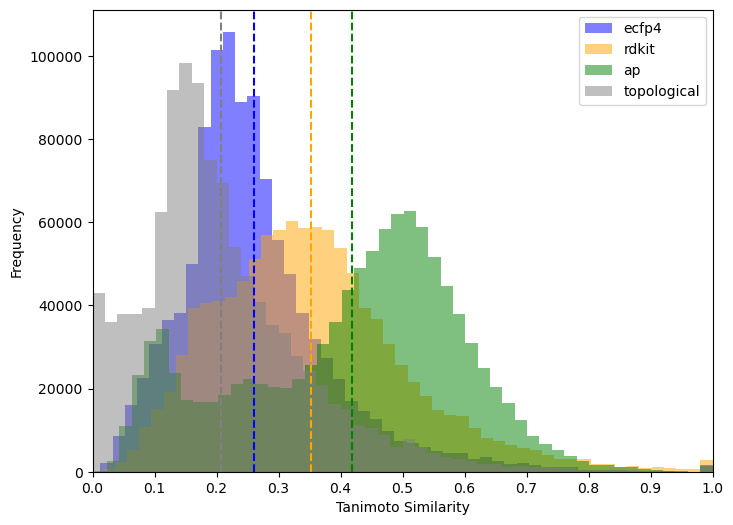

In [2]:
smiles_carotenoids = bblean.load_smiles('carotenoids.smi')
fps = {}
sims = {}
for fp_type in ['ecfp4', 'rdkit', 'ap', 'topological']:
    fps[fp_type] = bblean.fps_from_smiles(smiles_carotenoids, fp_type, n_features=2048)
    sims[fp_type] = iSIM.jt_sim_matrix_packed(fps[fp_type])

plot_distributions_by_fp(sims)

### Database comparison

Now, let's compare how different the distributions are for two databases: the carotenoid we used in the first section and a random sample of the size from ChEMBL. We can see how even the difference is bigger; hence we cannot just use the same value for all databases.

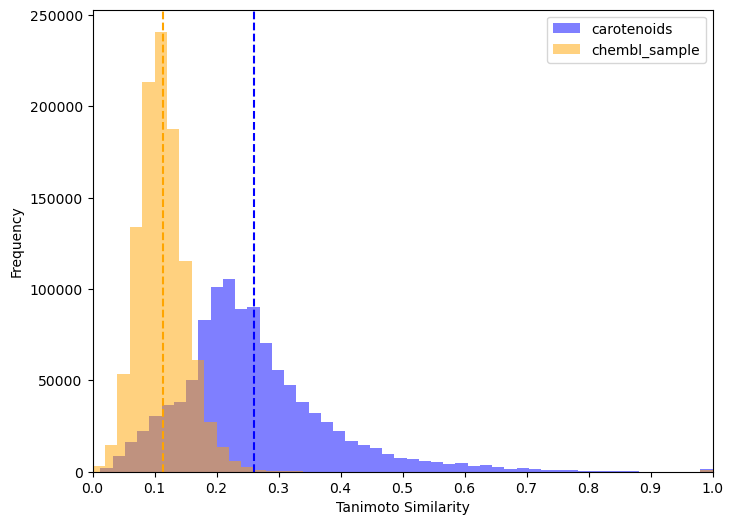

In [3]:
smiles_chembl = bblean.load_smiles('chembl.smi') #### Note: Download above file first
# Let's take a random sample of ChEMBL with the same size as the carotenoids dataset
smiles_chembl_sample = np.random.choice(smiles_chembl, size=len(smiles_carotenoids), replace=False)
chembl_sample_ecfp4 = bblean.fps_from_smiles(smiles_chembl_sample, 'ecfp4', n_features=2048)
ecfp4_sims = {'carotenoids': sims['ecfp4'],
              'chembl_sample': iSIM.jt_sim_matrix_packed(chembl_sample_ecfp4)}

plot_distributions_by_fp(ecfp4_sims)

### Selecting the optimal threshold

iSIM which is linear scaling way of calculating the average of the pairwise similarities without having to compute them. With iSIM, we can quickly obtain the average and use it as reference to select our threshold. 

For instance, for the two databases above:


In [4]:
# Let's get now the complete fingerprints for ChEMBL
chembl_ecfp4 = bblean.fps_from_smiles(smiles_chembl, kind = 'ecfp4')

In [6]:
# Calculating iSIM for both databases
iSIM_carotenoids = iSIM.jt_isim(fps['ecfp4'])
iSIM_chembl = iSIM.jt_isim(chembl_ecfp4)

print(f"iSIM Carotenoids ECFP4: {iSIM_carotenoids:.4f}")
print(f"iSIM ChEMBL ECFP4: {iSIM_chembl:.4f}")

iSIM Carotenoids ECFP4: 0.2496
iSIM ChEMBL ECFP4: 0.1126


We can see that in the distribution of ECFP4 fingerprints using typical values of what would be consider "similar" (e.g., 0.70), would not give the best results. BitBirch uses as merging criterion the iSIM of a subcluster, hence using a value that much larger than the average (e.g., 0.11 for ChEMBL) would give an extremely large number of singletons. 

We are going to use the standard deviation of the similarities to guide the threshold selection. But we won't have to calculate all the pairwise similarities, for the estimation of the standard deviation we will use iSIM-sigma, an efficient linear scaling aproach.

The differences in standard deviations are also significant.

In [ ]:
iSIM_sigma_carotenoids = iSIM.estimate_jt_std(fps['ecfp4'])
iSIM_sigma_chembl = iSIM.estimate_jt_std(chembl_ecfp4)

print(f"iSIM-sigma Carotenoids ECFP4: {iSIM_sigma_carotenoids:.4f}")
print(f"iSIM-sigma ChEMBL ECFP4: {iSIM_sigma_chembl:.4f}") # Rsults may vary due to this estimation not being deterministic

iSIM-sigma Carotenoids ECFP4: 0.1260
iSIM-sigma ChEMBL ECFP4: 0.0378


Takeaway:
- The distribution of similarities can highly differ between fingeprint types and databases. 
- iSIM and iSIM-sigma can be used as reference to define a threshold for each case.

### Cluster with informed thresholds

We now are going to test several thresholds in increasing standard deviation steps. For full calculations please use the `optimal_threshold.py` script contained in this directory. That script might take a while to run, since it tests several thresholds until 1.0

Here we loaded the precomputed results. We include the function to generate those values too.  

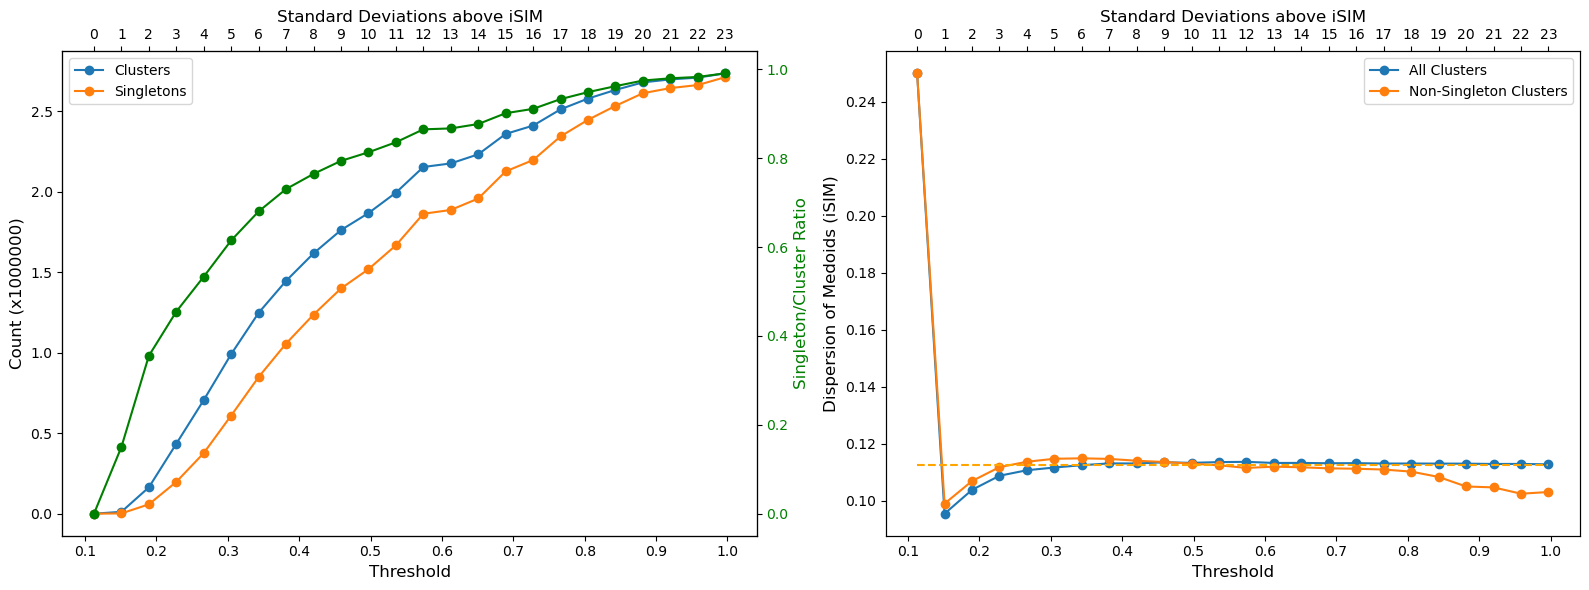

In [ ]:
#threshold_scan_df = threshold_scan(fps=chembl_ecfp4, # This is a largge db
#                                   max_sigmas=100, # Use less if the database is too large and not a full scan is needed
#                                   branching_factor=50,
#                                   save_path='chembl/chembl_ecfp4.csv') # This is just to replicate figure, we actually recommend higher values

threshold_scan_df = pd.read_csv('chembl/chembl_ecfp4.csv')

plot_threshold_scan(df = threshold_scan_df,
                    fps = chembl_ecfp4,
                    count_scale=1e6)

### Analysis for branching factor

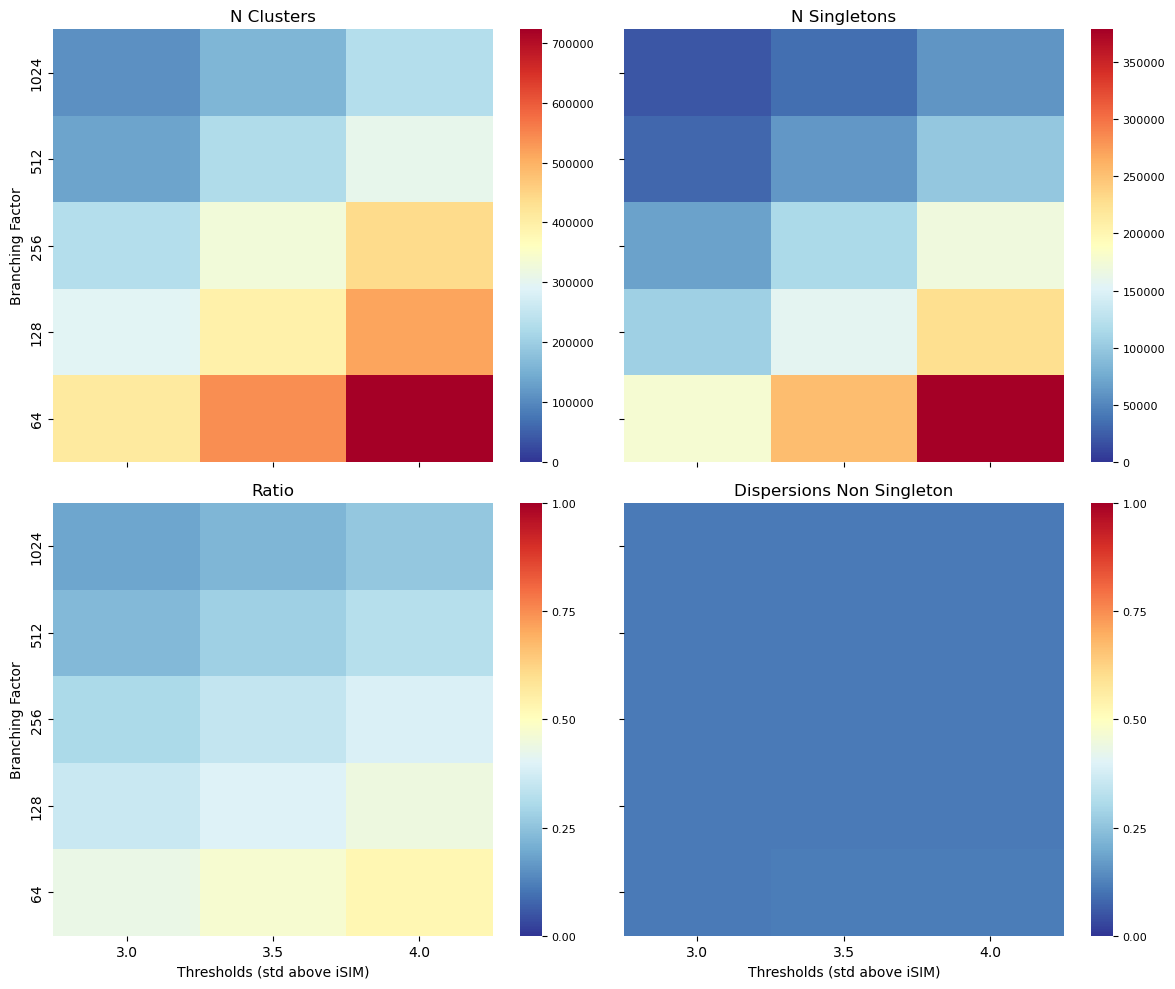

In [ ]:
# This is commented out to avoid long computations, but included here for completeness
# It generates the data for the branching factor scan figure
#branching_factor_scan_df = branching_factor_scan(fps=chembl_ecfp4,
#                                                 sigmas_list=[3.0, 3.5, 4.0],
#                                                 branching_factors=[10, 25, 50, 100, 200],
#                                                 save_path='chembl/chembl_branching_ecfp4.csv')

# We load the precomputed data instead
branching_factor_scan_df = pd.read_csv('chembl/chembl_branching_ecfp4.csv')

plot_branching_factor_scan(df=branching_factor_scan_df,
                           fps=chembl_ecfp4,
                           sigmas_list=[3.0, 3.5, 4.0])

### Populations and chemical structures of the clusters

Having determined that we are going to go with 3.5 standard deviations and a branching factor of 1024, now we take a look at the populations and quality of the clusters.

In [8]:
bbc = bblean.BitBirch(threshold=iSIM_chembl + 3.5 * iSIM_sigma_chembl,
                      branching_factor=1024,
                      merge_criterion='diameter')

bbc.fit(chembl_ecfp4)
clusters = bbc.get_cluster_mol_ids()

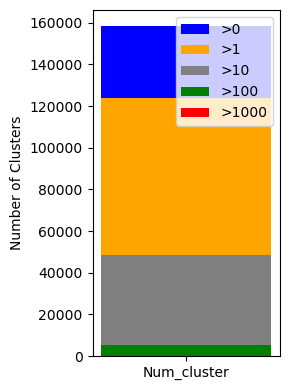

In [9]:
clusters_pop_plot(clusters)

(<Figure size 1250x625 with 2 Axes>,
 (<Axes: xlabel='Cluster label', ylabel='Num. molecules'>,
  <Axes: ylabel='Tanimoto iSIM (average similarity)'>))

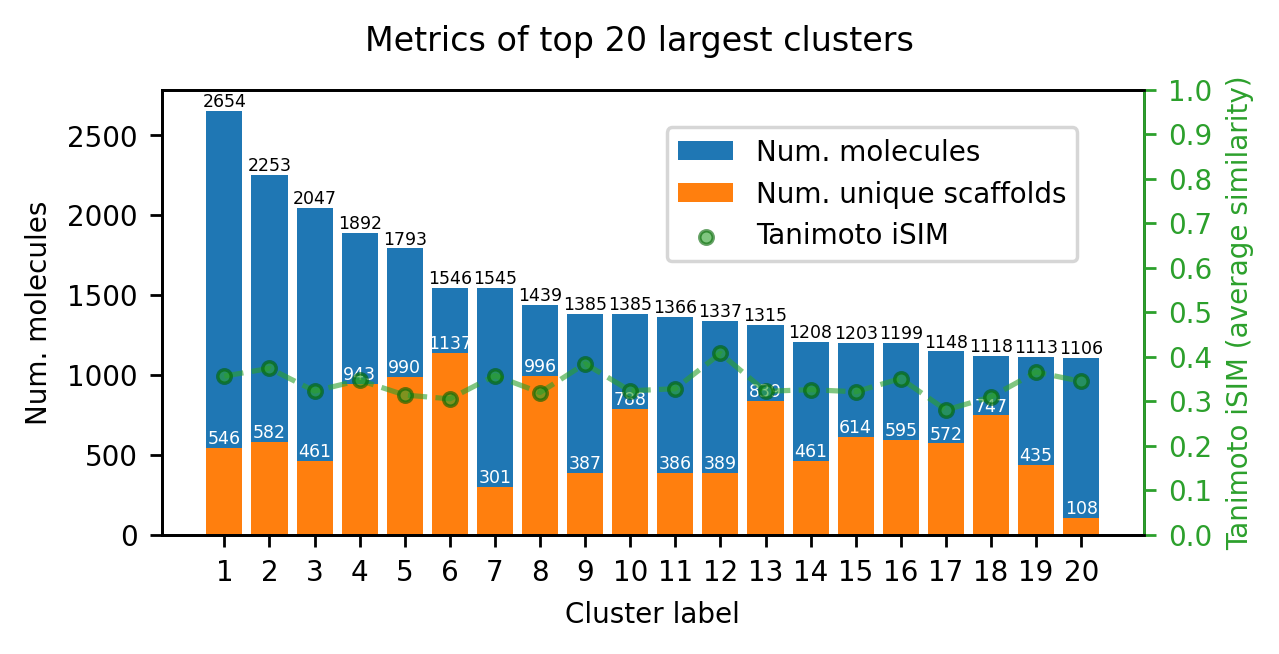

In [10]:
pop_analysis = analysis.cluster_analysis(clusters, smiles = smiles_chembl, fps = chembl_ecfp4)
plotting.summary_plot(pop_analysis)

With the following function we can get images for a random sample of molecules from a cluster and their MCS so we can asses the quality of the clusters.

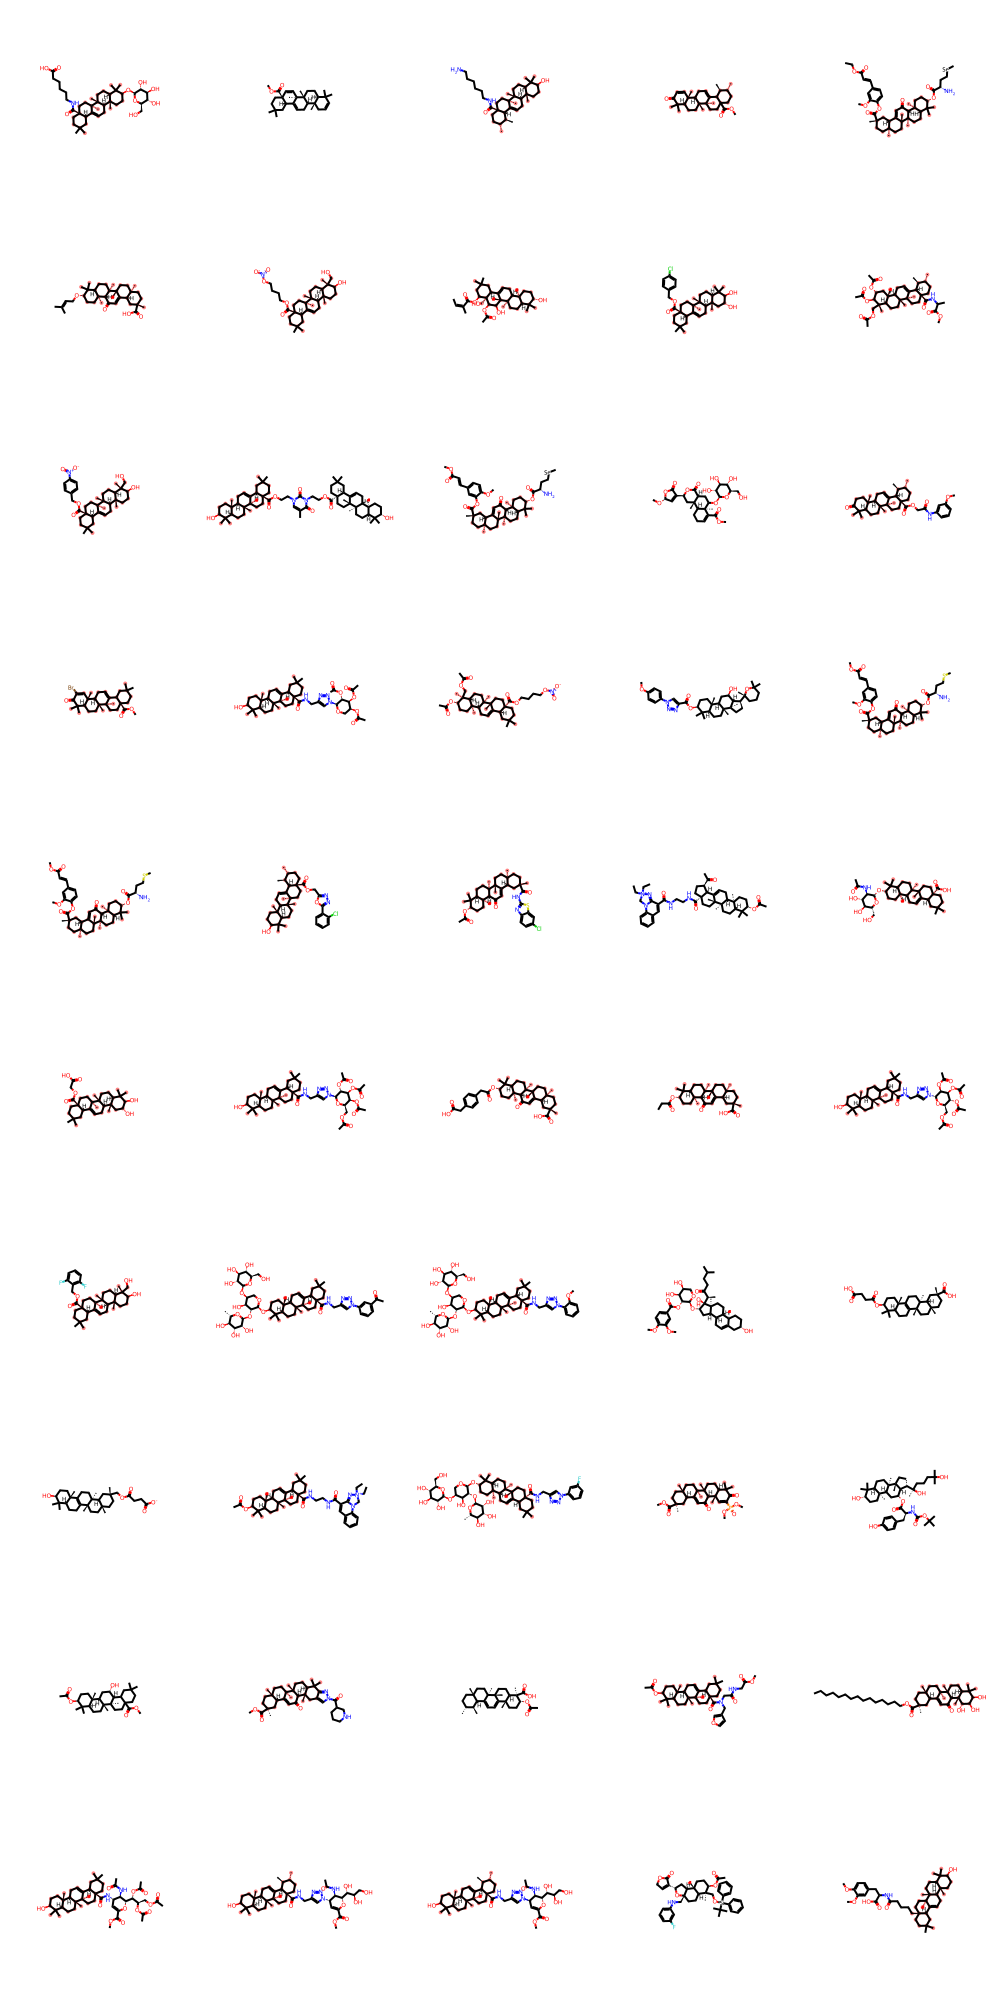

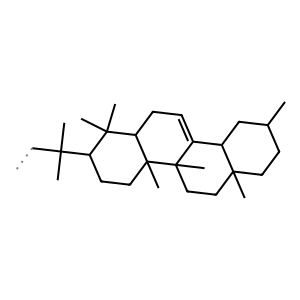

In [11]:
to_select = 0 # You can change this to visualize other clusters
img1, img2 = sampled_MSC(clusters[to_select], smiles=smiles_chembl, n_samples=50)
display(img1)
display(img2)

### Re-clustering

Re-clustering might not be needed for some databases or some goals. A good threshold and large branching factor could be enough to obtain good results, however we added this method in case it is needed. 

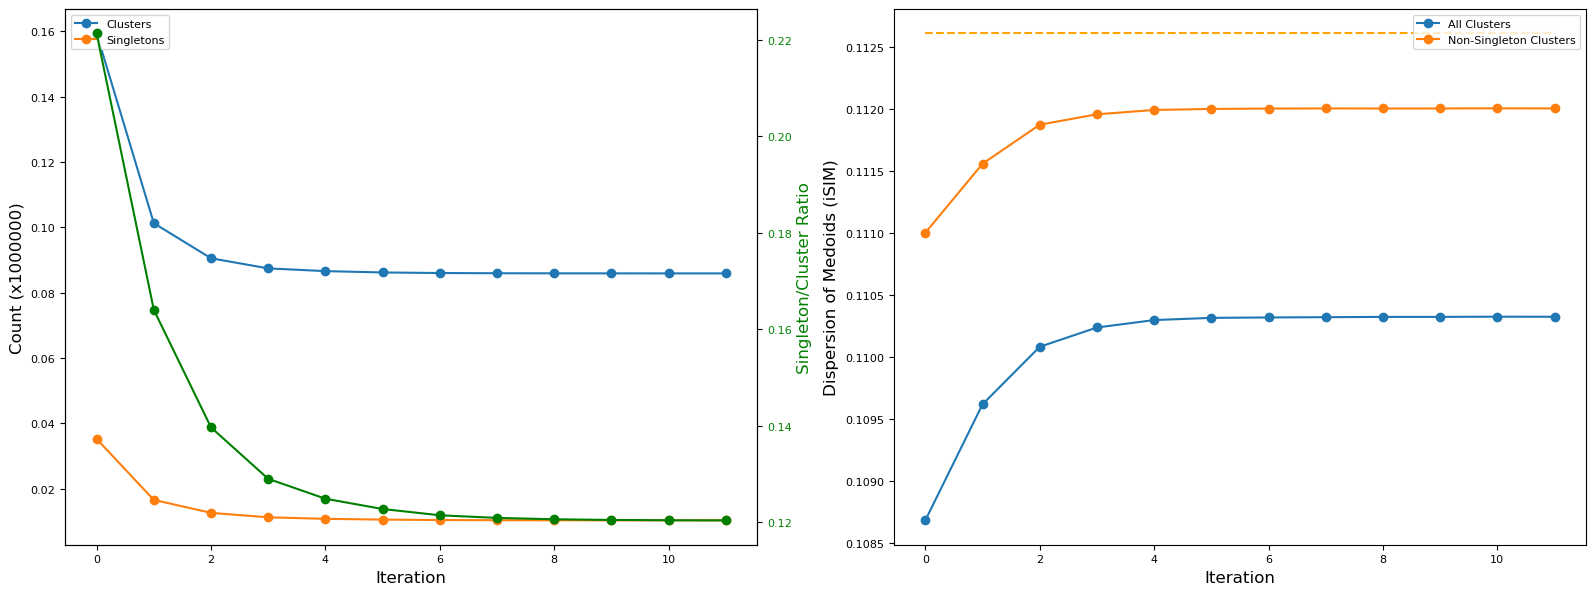

(<Figure size 1600x600 with 3 Axes>,
 array([<Axes: xlabel='Iteration', ylabel='Count (x1000000)'>,
        <Axes: xlabel='Iteration', ylabel='Dispersion of Medoids (iSIM)'>],
       dtype=object))

In [ ]:
# This is commented out to avoid long computations, but included here for completeness
#recluster_metrics = recluster_iteration_metrics(fps=chembl_ecfp4,
#                                                initial_threshold=iSIM_chembl + 3.5 * iSIM_sigma_chembl,
#                                                extra=1,
#                                                iterations=11,
#                                                branching_factor=1024,
#                                                save_path='chembl/ecfp4_refinement_3.5_1.csv)

recluster_metrics = pd.read_csv('chembl/ecfp4_refinement_3.5_1.csv')

plot_cluster_refinement(recluster_metrics,
                        fps=chembl_ecfp4,
                        count_scale=1e6)

We are going to obtain the clusters at the fifth iteration to evaluate some of the structures, and visualize the flow.
For this we are going to use the bbc object we fitted above.

In [12]:
bbc.recluster_inplace(iterations=5,
                      extra_threshold=1 * iSIM_sigma_chembl,
                      verbose=True)

clusters_after = bbc.get_cluster_mol_ids()

Current number of clusters: 158219
Current number of singletons: 34327
Current number of clusters: 98859
Current number of singletons: 15587
Current number of clusters: 89360
Current number of singletons: 12055
Current number of clusters: 86747
Current number of singletons: 10953
Current number of clusters: 85766
Current number of singletons: 10462
Final number of clusters: 85385
Final number of singletons: 10214


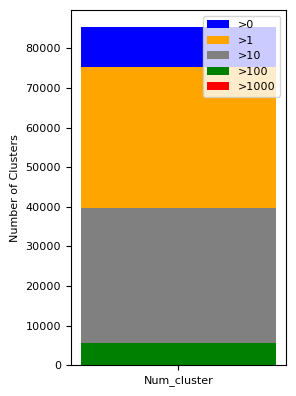

In [15]:
clusters_pop_plot(clusters_after)

In [13]:
sankey_cluster_flow(clusters, clusters_after,
                    min_flow=1000,
                    top_n=15)